# Computing saliency masks with the PAIRML saliency library

This notebook demonstrates a number of saliency mask techniques, augmented with the `SmoothGrad` technique, using the Inception V3 convolutional neural network. The intention of this notebook is to have as few dependencies as possible to show how to compute masks.

This notebook shows the following techniques, alongside with the `SmoothGrad` augmentation:

*   Vanilla Gradients
    ([paper](https://scholar.google.com/scholar?q=Visualizing+higher-layer+features+of+a+deep+network&btnG=&hl=en&as_sdt=0%2C22),
    [paper](https://arxiv.org/abs/1312.6034))
*   Guided Backpropogation ([paper](https://arxiv.org/abs/1412.6806))
*   Integrated Gradients ([paper](https://arxiv.org/abs/1703.01365))
*   Occlusion

This notebook assumes you have the `saliency` pip package installed. To install run (use `pip3` for python 3.x):
```
pip install saliency
```

In [2]:
# Boilerplate imports.
import tensorflow.compat.v1 as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P
import pickle
import os
# slim=tf.contrib.slim
# 1. Install tf_slim using: pip install git+https://github.com/adrianc-a/tf-slim.git@remove_contrib
# 2. Replace imports of slim with import tf_slim as slim 
#    in the models/research/slim folder - in inception_v3.py and inception_utils.py.
import tf_slim as slim

if not os.path.exists('models/research/slim'):
  !git clone https://github.com/tensorflow/models/
old_cwd = os.getcwd()
os.chdir('models/research/slim')
from nets import inception_v3
os.chdir(old_cwd)

# From our repository.
import saliency

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [3]:
import tensorflow
tensorflow.__version__

'1.15.0'

### Loading the Inception model graph

Run the following cell to download the network. Alternatively, the pretrained network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). Unpack the tensorflow_inception_graph.pb file from the archive and set its path to model_fn variable.

In [4]:
# Use either wget or curl depending on your OS.
if not os.path.exists('inception_v3.ckpt'):
  #!wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
  !curl -O http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
  !tar -xvzf inception_v3_2016_08_28.tar.gz

ckpt_file = './inception_v3.ckpt'

In [5]:
import wget
wget.download("http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz")

'inception_v3_2016_08_28.tar.gz'

In [5]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  im = ((im + 1) * 127.5).astype(np.uint8)
  P.imshow(im)
  P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im, cmap='inferno')
  P.title(title)

def ShowDivergingImage(grad, title='', percentile=99, ax=None):  
  if ax is None:
    fig, ax = P.subplots()
  else:
    fig = ax.figure
  
  P.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  im = ax.imshow(grad, cmap=P.cm.coolwarm, vmin=-1, vmax=1)
  fig.colorbar(im, cax=cax, orientation='vertical')
  P.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = np.asarray(im)
  return im / 127.5 - 1.0

### Adding a single logit tensor for which we want to compute the mask

In [6]:
graph = tf.Graph()

with graph.as_default():
  images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

  with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
    _, end_points = inception_v3.inception_v3(images, is_training=False, num_classes=1001)
    
    # Restore the checkpoint
    sess = tf.Session(graph=graph)
    saver = tf.train.Saver()
    saver.restore(sess, ckpt_file)
    
  # Construct the scalar neuron tensor.
  logits = graph.get_tensor_by_name('InceptionV3/Logits/SpatialSqueeze:0')
  neuron_selector = tf.placeholder(tf.int32)
  y = logits[0][neuron_selector]
    
  # Construct tensor for predictions.
  prediction = tf.argmax(logits, 1)

Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt


In [19]:
[n.name for n in tf.get_default_graph().as_graph_def().node][-10:]

['VarIsInitializedOp_370',
 'VarIsInitializedOp_371',
 'VarIsInitializedOp_372',
 'VarIsInitializedOp_373',
 'VarIsInitializedOp_374',
 'VarIsInitializedOp_375',
 'VarIsInitializedOp_376',
 'VarIsInitializedOp_377',
 'init',
 'predict/group_deps']

In [7]:
!ls

CONTRIBUTING.md                history-of-saliency.ipynb
Examples.ipynb                 inception_v3.ckpt
LICENSE                        inception_v3_2016_08_28.tar.gz
README.md                      models
build                          saliency
dist                           saliency.egg-info
doberman.png                   setup.cfg
docs                           setup.py
dog.png                        update_pip_package.sh


### Load an image and infer

Prediction class: 237


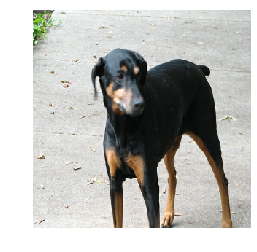

In [8]:
# Load the image
im = LoadImage('./doberman.png')

# Show the image
ShowImage(im)

# Make a prediction. 
prediction_class = sess.run(prediction, feed_dict = {images: [im]})[0]

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 237

### Vanilla Gradient & SmoothGrad

In [13]:
gradient_saliency = saliency.GradientSaliency(graph, sess, y, images)
guided_backprop = saliency.GuidedBackprop(graph, sess, y, images)
integrated_gradients = saliency.IntegratedGradients(graph, sess, y, images)
blur_ig = saliency.BlurIG(graph, sess, y, images)
xrai_v = saliency.XRAI(graph, sess, y, images)
gcam = saliency.GradCam(graph, sess, y, images, graph.get_tensor_by_name("Conv/BiasAdd:0"))

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


KeyError: "The name 'Conv/BiasAdd:0' refers to a Tensor which does not exist. The operation, 'Conv/BiasAdd', does not exist in the graph."

In [10]:
def vanilla_saliency(image):
    image = image / 127.5 - 1.0
    prediction_class = sess.run(prediction, feed_dict = {images: [image]})[0]
    vanilla_mask_3d = gradient_saliency.GetMask(image, feed_dict = {neuron_selector: prediction_class})
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
    return vanilla_mask_grayscale.tolist()

def smoothgrad_saliency(image):
    image = image / 127.5 - 1.0
    prediction_class = sess.run(prediction, feed_dict = {images: [image]})[0]
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(image, feed_dict = {neuron_selector: prediction_class})
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)
    return smoothgrad_mask_grayscale.tolist()

def guided_vanilla(image):
    image = image / 127.5 - 1.0
    prediction_class = sess.run(prediction, feed_dict = {images: [image]})[0]
    vanilla_guided_backprop_mask_3d = guided_backprop.GetMask(
    image, feed_dict = {neuron_selector: prediction_class})
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_guided_backprop_mask_3d)
    return vanilla_mask_grayscale.tolist()

def guided_smoothgrad(image):
    image = image / 127.5 - 1.0
    prediction_class = sess.run(prediction, feed_dict = {images: [image]})[0]
    smoothgrad_guided_backprop_mask_3d = guided_backprop.GetSmoothedMask(
    image, feed_dict = {neuron_selector: prediction_class})
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_guided_backprop_mask_3d)
    return smoothgrad_mask_grayscale.tolist()

def integrated_vanilla(image):
    image = image / 127.5 - 1.0
    prediction_class = sess.run(prediction, feed_dict = {images: [image]})[0]
    baseline = np.zeros(image.shape)
    baseline.fill(-1)
    vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
    image, feed_dict = {neuron_selector: prediction_class}, x_steps=25, x_baseline=baseline)
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
    return vanilla_mask_grayscale.tolist()

def integrated_smoothgrad(image):
    image = image / 127.5 - 1.0
    prediction_class = sess.run(prediction, feed_dict = {images: [image]})[0]
    baseline = np.zeros(image.shape)
    baseline.fill(-1)
    smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
    image, feed_dict = {neuron_selector: prediction_class}, x_steps=25, x_baseline=baseline)
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)
    return smoothgrad_mask_grayscale.tolist()

def blur_IG_vanilla(image):
    image = image / 127.5 - 1.0
    prediction_class = sess.run(prediction, feed_dict = {images: [image]})[0]
    baseline = np.zeros(image.shape)
    baseline.fill(-1)

    blur_ig_mask_3d = blur_ig.GetMask(
    image, feed_dict = {neuron_selector: prediction_class})

    blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)
    return blur_ig_mask_grayscale.tolist()

def blur_IG_smoothgrad(image):
    image = image / 127.5 - 1.0
    prediction_class = sess.run(prediction, feed_dict = {images: [image]})[0]
    baseline = np.zeros(image.shape)
    baseline.fill(-1)

    blur_ig_mask_3d = blur_ig.GetSmoothedMask(
    image, feed_dict = {neuron_selector: prediction_class})

    blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)
    return blur_ig_mask_grayscale.tolist()

def xrai_vanilla(image):
    image = image / 127.5 - 1.0
    prediction_class = sess.run(prediction, feed_dict = {images: [image]})[0]
    xrai_mask_3d = xrai_v.GetMask(image, feed_dict = {neuron_selector: prediction_class})
    xrai_mask_grayscale = saliency.VisualizeImageGrayscale(xrai_mask_3d)
    return xrai_mask_grayscale.tolist()

In [11]:
import requests
from urllib.request import urlretrieve
import gradio as gr

# Download human-readable labels for ImageNet.
inception_net = tf.keras.applications.InceptionV3() # load the model

# Download human-readable labels for ImageNet.
response = requests.get("https://git.io/JJkYN")
labels = response.text.split("\n")

def classify_image(inp):
    inp = inp.reshape((-1, 299, 299, 3))
    inp = tf.keras.applications.inception_v3.preprocess_input(inp)
    prediction = inception_net.predict(inp).flatten()
    return {labels[i]: float(prediction[i]) for i in range(1000)}

image = gr.inputs.Image(shape=(299, 299, 3))
label = gr.outputs.Label(num_top_classes=3)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
gr.Interface(classify_image, image, label, capture_session=True, interpretation=blur_IG_smoothgrad, allow_flagging=False).launch()

Running locally at: http://127.0.0.1:7861/
To get a public link for a hosted model, set Share=True
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7861/', None)

In [131]:
gr.Interface(classify_image, image, label, capture_session=True, interpretation=vanilla_saliency, allow_flagging=False).launch()

Running locally at: http://127.0.0.1:7879/
To get a public link for a hosted model, set Share=True
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7879/', None)

In [19]:
gr.Interface(classify_image, image, label, capture_session=True, interpretation=integrated_smoothgrad, allow_flagging=False).launch()

Running locally at: http://127.0.0.1:7865/
To get a public link for a hosted model, set Share=True
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7865/', None)

In [17]:
gr.Interface(classify_image, image, label, capture_session=True, interpretation=guided_smoothgrad).launch()

Running locally at: http://127.0.0.1:7863/
To get a public link for a hosted model, set Share=True
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7863/', None)

In [20]:
gr.Interface(classify_image, image, label, capture_session=True, interpretation=integrated_vanilla).launch()

Running locally at: http://127.0.0.1:7864/
To get a public link for a hosted model, set Share=True
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7864/', None)

In [21]:
gr.Interface(classify_image, image, label, capture_session=True, interpretation=blur_IG_vanilla).launch()

Running locally at: http://127.0.0.1:7865/
To get a public link for a hosted model, set Share=True
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7865/', None)

In [18]:
gr.Interface(classify_image, image, label, capture_session=True, interpretation=smoothgrad_saliency).launch()

Running locally at: http://127.0.0.1:7862/
To get a public link for a hosted model, set Share=True
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7862/', None)

In [25]:
gr.Interface(classify_image, image, label, capture_session=True, interpretation=guided_smoothgrad).launch()

Running locally at: http://127.0.0.1:7869/
To get a public link for a hosted model, set Share=True
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7869/', None)

In [23]:
gr.Interface(classify_image, image, label, capture_session=True, interpretation=integrated_smoothgrad).launch()

Running locally at: http://127.0.0.1:7867/
To get a public link for a hosted model, set Share=True
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7867/', None)

In [24]:
gr.Interface(classify_image, image, label, capture_session=True, interpretation=blur_IG_smoothgrad).launch()

Running locally at: http://127.0.0.1:7868/
To get a public link for a hosted model, set Share=True
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7868/', None)

In [28]:
gr.reset_all()